# **Vehicles Routing Problem (VRP) with Time Windows with Visuzlisation**

### Mann Bajpai
### IDD CSE
### 21CS2011

### Download and Import the dependencies

In [4]:
!pip install ortools matplotlib folium

In [5]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import folium
import random

### Create Data Model for the Problem

In [6]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["time_matrix"] = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data["time_windows"] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (16, 18),  # 3
        (10, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 4),  # 7
        (5, 10),  # 8
        (0, 3),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 8),  # 14
        (10, 15),  # 15
        (11, 15),  # 16
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    num_locations = len(data["time_matrix"])
    data["locations"] = [(random.uniform(-10, 10), random.uniform(-10, 10)) for _ in range(num_locations)]
    return data

### Getting the results on the console

In [7]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    time_dimension = routing.GetDimensionOrDie("Time")
    total_time = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += (
                f"{manager.IndexToNode(index)}"
                f" Time({solution.Min(time_var)},{solution.Max(time_var)})"
                " -> "
            )
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += (
            f"{manager.IndexToNode(index)}"
            f" Time({solution.Min(time_var)},{solution.Max(time_var)})\n"
        )
        plan_output += f"Time of the route: {solution.Min(time_var)}min\n"
        print(plan_output)
        total_time += solution.Min(time_var)
    print(f"Total time of all routes: {total_time}min")

### Plot the Routes using Matplotlib

In [8]:
def plot_routes(data, manager, routing, solution):
    """Plot routes using Matplotlib."""
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Vehicle Routing Problem with Time Windows (Matplotlib)")
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        route.append(manager.IndexToNode(routing.End(vehicle_id)))
        plt.plot(
            [data["locations"][i][0] for i in route],
            [data["locations"][i][1] for i in route],
            marker="o",
            linestyle="-",
            label=f"Route {vehicle_id}",
        )
    plt.legend()
    plt.show()

### Plot the Map using Folium and save it

In [9]:
def plot_map(data, manager, routing, solution):
    """Plot routes using Folium."""
    m = folium.Map(location=[data["locations"][data["depot"]][0], data["locations"][data["depot"]][1]], zoom_start=10)
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        route.append(manager.IndexToNode(routing.End(vehicle_id)))
        route_points = [(data["locations"][i][0], data["locations"][i][1]) for i in route]
        folium.PolyLine(locations=route_points, color='blue').add_to(m)
    m.save("vrptw_map.html")

### Main VRP Algorithm

Objective: 71
Route for vehicle 0:
0 Time(0,0) -> 9 Time(2,3) -> 14 Time(7,8) -> 16 Time(11,11) -> 0 Time(18,18)
Time of the route: 18min

Route for vehicle 1:
0 Time(0,0) -> 7 Time(2,4) -> 1 Time(7,11) -> 4 Time(10,13) -> 3 Time(16,16) -> 0 Time(24,24)
Time of the route: 24min

Route for vehicle 2:
0 Time(0,0) -> 12 Time(4,4) -> 13 Time(6,6) -> 15 Time(11,11) -> 11 Time(14,14) -> 0 Time(20,20)
Time of the route: 20min

Route for vehicle 3:
0 Time(0,0) -> 5 Time(3,3) -> 8 Time(5,5) -> 6 Time(7,7) -> 2 Time(10,10) -> 10 Time(14,14) -> 0 Time(20,20)
Time of the route: 20min

Total time of all routes: 82min


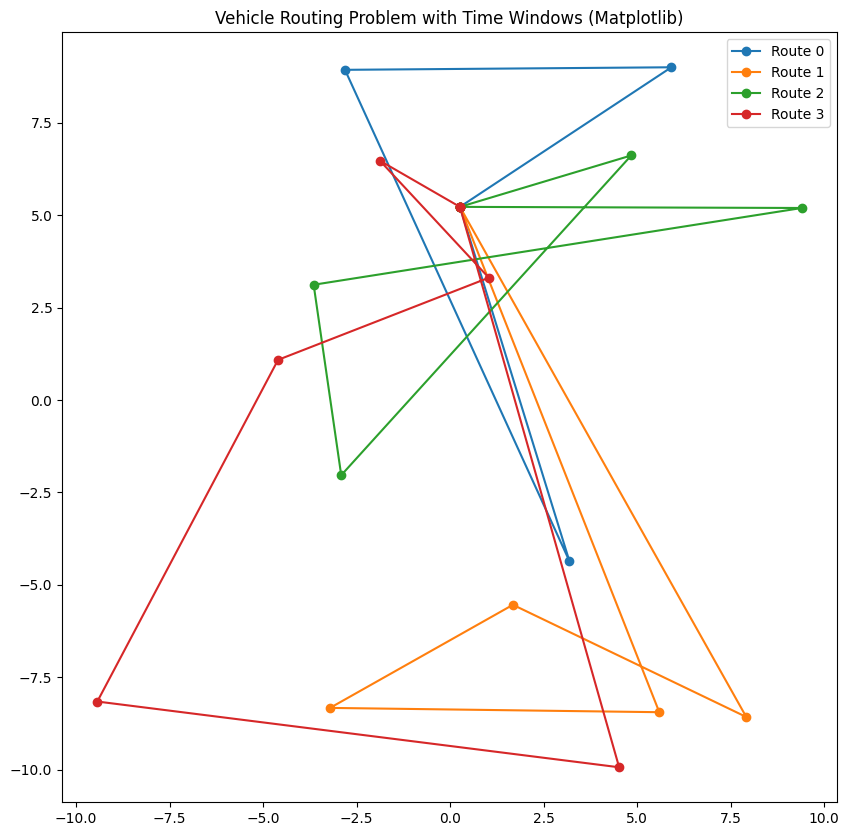

In [10]:
def main():
    """Solve the VRP with time windows."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["time_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Time Windows constraint.
    time = "Time"
    routing.AddDimension(
        transit_callback_index,
        30,  # allow waiting time
        30,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time,
    )
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data["time_windows"]):
        if location_idx == data["depot"]:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each vehicle start node.
    depot_idx = data["depot"]
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            data["time_windows"][depot_idx][0], data["time_windows"][depot_idx][1]
        )

    # Instantiate route start and end times to produce feasible times.
    for i in range(data["num_vehicles"]):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i))
        )
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
        plot_routes(data, manager, routing, solution)
        plot_map(data, manager, routing, solution)


if __name__ == "__main__":
    main()
